In [ ]:
import numpy as np
import random
from PIL import Image, ImageDraw
from IPython.display import display

In [ ]:
# This program is supposed to be simulation based on evolving cellular automaton.
# Simulation assumptions made:

# 1) 4 cell states are possible: tree, burning tree, burned tree, water.
# 2) The first burning tree is created by spontaneous combustion of a random tree on the
# map.
# 3) It is possible to set the probability of self-ignition of another tree.
# 4) A cell can change its state from a tree to a burning tree by taking a
# fire from an already burning tree if they border each other.  Ignition
# occurs at the next generation, with probability p.
# 5) If a tree borders more than one burning tree, the following is checked
# ignition event is checked, from each of the trees. For example, if a tree
# borders two burning trees, then if it does not ignite from the first one,
# there is a probability p that it will ignite from the second burning tree.
# 6) The burning tree turns into a burned tree in the next generation.
# 7) After k generations have passed, the tree grows back - the burned tree turns into a
# tree.
# 8) Water provides a barrier to fire.
# 9) The presence of wind is taken into account. The wind may not currently be blowing, or it may be blowing
# in one of the four basic directions of the world.
# 10) The wind can blow at different strengths - 4 degrees of wind power are provided.
# 11) The wind has a chance in each generation to randomly change its direction of blowing(or stop
# blowing) and the power with which it blows.
# 12) The blowing wind causes an increase in the probability of ignition of a tree, in the
# the direction of the blowing wind, by the value of s, and a decrease in the probability of ignition of a tree,
# standing on the opposite side to the wind direction, by the value of s.
# 13) The simulation ends when there is no longer any burning tree on the map.


In [ ]:

def generate_map(width, height, burning_trees, water_percentage):
    total_cells = width * height
# generating map function array where
  # 0- tree
  # 1- burning tree
  # 2- burned down tree
  # 3- water

    # adjusting water cells amount based on inputted percentage
    water_cells = int(total_cells * water_percentage / 100)

    # initiating map as an array of zeros == trees
    map = np.zeros((height, width), dtype=int)

    # adding water area to map
    water_added = 0
    while water_added < water_cells:
        # starting point in water area generation
        row = random.randint(0, height - 1)
        col = random.randint(0, width - 1)

         # Avoid overwriting water
        if map[row, col] != 3:
            map[row, col] = 3
            water_added += 1

            # Growing the cluster
             # Adjust the range for cluster size
            cluster_size = random.randint(5, 30)
            for _ in range(cluster_size):
                if water_added >= water_cells:
                    break

                # Choose a random neighboring cell (4-connected)
                neighbors = [
                    (row + 1, col),
                    (row - 1, col),
                    (row, col + 1),
                    (row, col - 1),
                ]
                random.shuffle(neighbors)
                for r, c in neighbors:
                    if 0 <= r < height and 0 <= c < width and map[r, c] != 3:
                        map[r, c] = 3
                        water_added += 1
                        # Move to this cell for further expansion
                        row, col = r, c
                        break

    # adding burning trees
    burning_trees_added = 0
    while burning_trees_added < burning_trees:
        r = random.randint(0, height - 1)
        c = random.randint(0, width - 1)

        if map[r, c] == 0:
            map[r, c] = 1
            burning_trees_added += 1

    return map


In [ ]:
def  visualize_map(map, tile_size=20):

# map visulazation function, based on pillow library
  # tree - green color
  # burning tree - red color
  # burned down tree - black color
  # water - blue color

    colors = {
        0: (34, 139, 34),
        1: (255, 0, 0),
        2: (0, 0, 0),
        3: (0 ,0, 255)
    }

    rows = len(map)
    cols = len(map[0]) if rows > 0 else 0


    width = cols * tile_size
    height = rows * tile_size
    img = Image.new("RGB", (width, height))
    pixels = img.load()

    for i in range(rows):
        for j in range(cols):
            color = colors.get(map[i][j], (255, 255, 255))
            for x in range(tile_size):
                for y in range(tile_size):
                    pixels[j * tile_size + x, i * tile_size + y] = color

    return img

In [ ]:
def next_generation(map, timer, p=0.3, k=10, wind='NO', wind_mod=2, random_ignition=0):

  height, width = map.shape

   # possible wind states and possibility modificators(wind force)
    # NO - no wind at all
    # W - Western wind
    # E - Eastern wind
    # N - Northern wind
    # S - Southner wind


  winds=['NO', 'S', 'N', 'E', 'W']
  wind_mods=[0.05, 0.10, 0.15, 0.20]
  wind_mod=wind_mods[wind_mod]

  new_wind=random.choice(winds)
  new_mod=random.choice(wind_mods)

  # chance of wind direction change:

  if random.random() < 0.15 and new_wind != wind:
    wind=new_wind

  # chance of wind force change:

  if random.random() < 0.3 and new_mod != wind_mod:
    wind_mod=new_mod


  new_map = map.copy()

  # timer for burned downed trees. After k generetions, tree will grow up again

  for x in range(height):
    for y in range(width):

      if new_map[x, y] == 1:
        new_map[x, y] = 2
        timer[x,y]=0.1

      if timer[x,y]!= 0:
        timer[x,y]+=1

      if timer[x,y]> k+1:
        new_map[x,y]=0
        timer[x,y]=0

  # calculating every cell new state

  for x in range(height):
    for y in range(width):

      # cell surronding(every touiching cell) gets aggregated into single list
      if map[x, y] == 0:
        surroundings = []

        for dx in [-1, 0, 1]:
          for dy in [-1, 0, 1]:

            if dx == 0 and dy == 0:
              continue

            nx, ny = x + dx, y + dy
            if 0 <= nx < height and 0 <= ny < width:
              surroundings.append((map[nx, ny], nx, ny))

        # cell under consideration gets a chance to be fired up, by every single already burning cell

        for tile in surroundings:

          # No wind case

          if wind=='NO':
            if tile[0] == 1 and random.random() < p:
              new_map[x, y] = 1
              break

          # South wind case

          if wind=='S':
            if tile[1]>x:
              if tile[0]==1 and random.random() < p-wind_mod:
                new_map[x, y] = 1
                break

            if tile[1]<x:
              if tile[0]==1 and random.random() < p+wind_mod:
                new_map[x, y] = 1
                break

          # North wind case

          if wind=='N':
            if tile[1]<x:
              if tile[0]==1 and random.random() < p-wind_mod:
                new_map[x, y] = 1
                break

            if tile[1]>x:
              if tile[0]==1 and random.random() < p+wind_mod:
                new_map[x, y] = 1
                break

          # East wind case

          if wind=='E':
            if tile[2]>y:
              if tile[0]==1 and random.random() < p-wind_mod:
                new_map[x, y] = 1
                break

            if tile[2]<y:
              if tile[0]==1 and random.random() < p+wind_mod:
                new_map[x, y] = 1
                break

          # West wind case

          if wind=='W':
            if tile[2]<y:
              if tile[0]==1 and random.random() < p-wind_mod:
                new_map[x, y] = 1
                break

            if tile[2]>y:
              if tile[0]==1 and random.random() < p+wind_mod:
                new_map[x, y] = 1
                break

    # random tree ingnition case
  if random_ignition > 0 and random.random() < random_ignition:
    ingited = (random.randint(0, height - 1), random.randint(0, width - 1))
    while map[ingited] != 0:
      ingited = (random.randint(0, height - 1), random.randint(0, width - 1))
    new_map[ingited] = 1




  return new_map, timer

In [ ]:
def control_function():

  # this function allows to control simulation parameters

  width=15 #map width // int

  height=15 #map height // int

  burning_trees=1 #starting burning trees amount // int

  water_percentage=10 #map water percentege // int considered as percent

  p=0.3 #probability of ignition from burning tree // float decimal fraction, less than 1.

  k=3 #number of generations to grew a new tree from a burnded one// int

  wind='NO' #starting wind direction possibly(NO, N, S, E, W)// string

  wind_mod=2 #starting ignition probability modifier from wind // int from <0:3>. Higher number means stronger wind.

  random_ignition=0 #chance of random tree ignition // float decimal fraction, less tahn 1.

  return width, height, burning_trees, water_percentage, p, k, wind, wind_mod, random_ignition

In [ ]:
def Start_simulation():

  width, height, burning_trees, water_percentage, p, k, wind, wind_mod, random_ignition= control_function()

  map= generate_map(width,height,burning_trees,water_percentage)

  timer= np.zeros(map.shape)
  map_vis=visualize_map(map)
  display(map_vis)

  while 1 in map:
    print('\n')
    map, timer=next_generation(map, timer, p, k, wind, wind_mod, random_ignition)
    map_vis=visualize_map(map)
    display(map_vis)

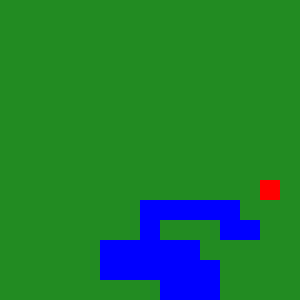

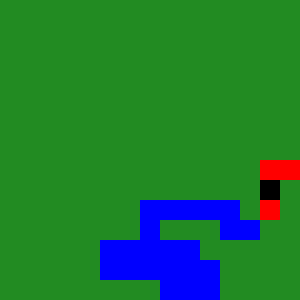

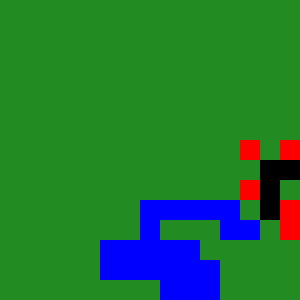

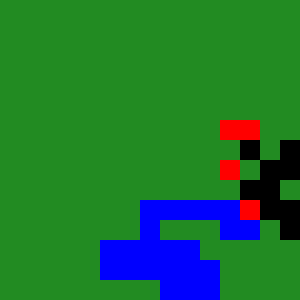

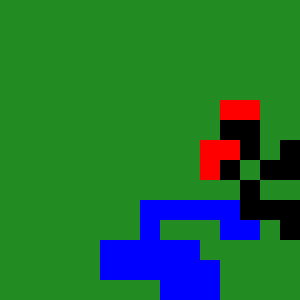

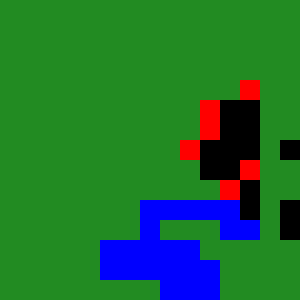

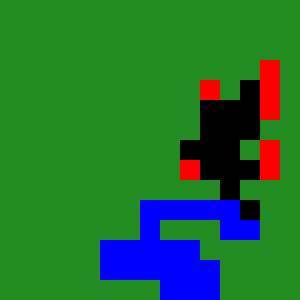

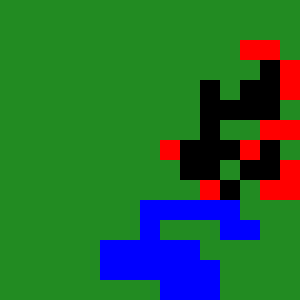

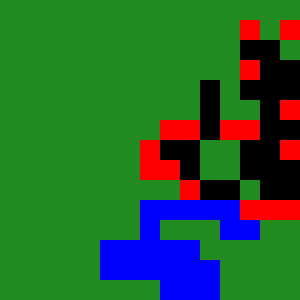

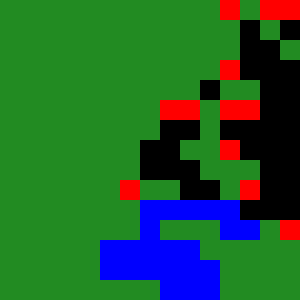

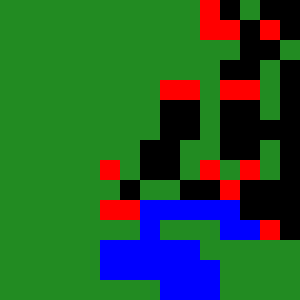

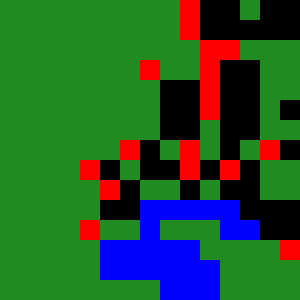

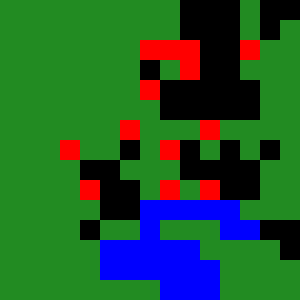

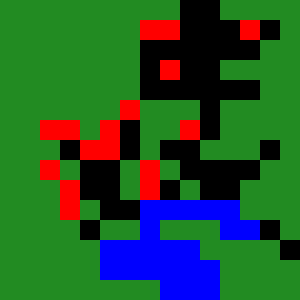

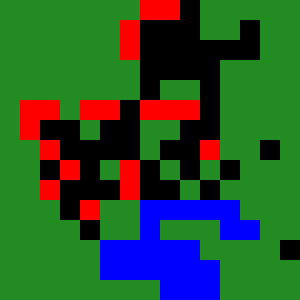

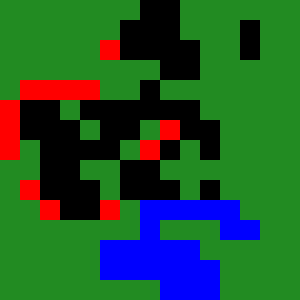

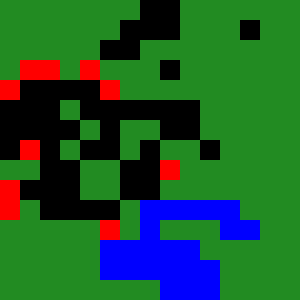

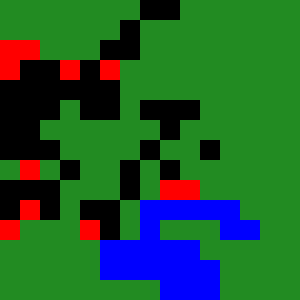

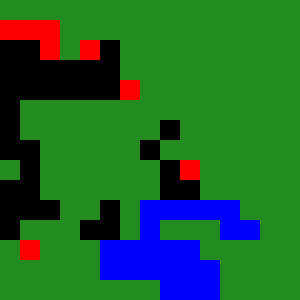

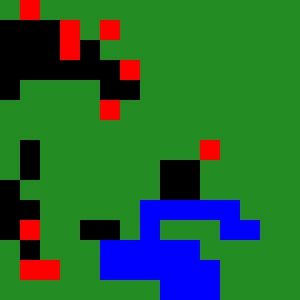

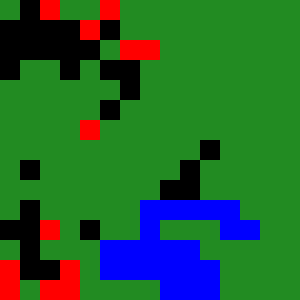

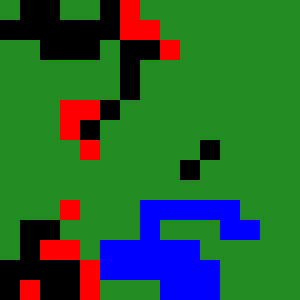

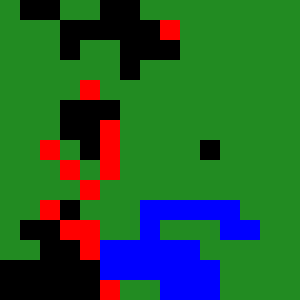

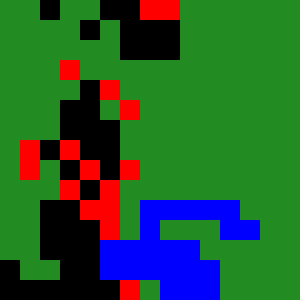

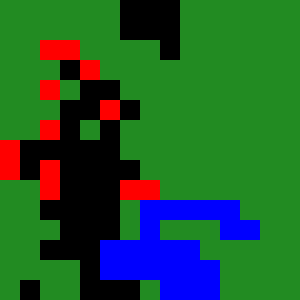

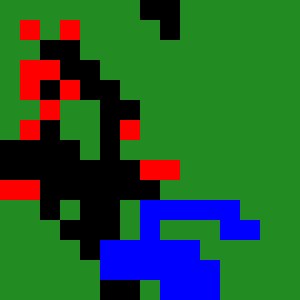

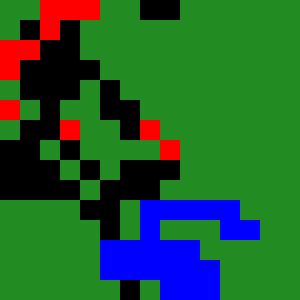

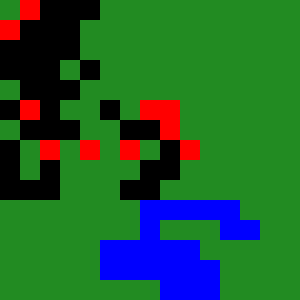

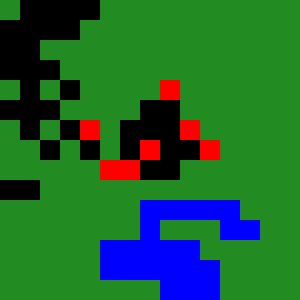

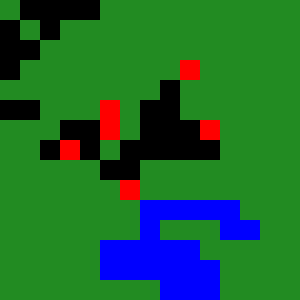

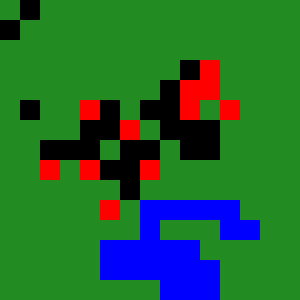

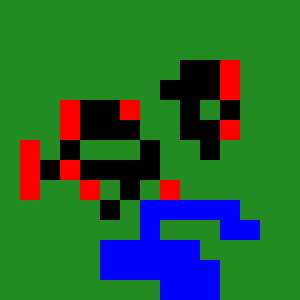

In [ ]:
Start_simulation()